In [1]:
# 以沪深300数据集为例，构建特征和目标值，使用线性回归模型(OLS方法)拟合特征与目标值，并评估模型
import pandas as pd
from scutquant import scutquant, alpha

In [2]:
# 读取数据
df = pd.read_csv('D:/Desktop/csi300.csv')
df.set_index(['datetime', 'instrument'], inplace=True)
df

open      close       high        low  \
datetime   instrument                                               
2014-01-02 SH600000     6.346357   6.346357   6.427982   6.319149   
           SH600008     2.669297   2.669297   2.693094   2.649466   
           SH600009     2.104700   2.104700   2.110510   2.077102   
           SH600010     3.032141   3.032141   3.032141   3.032141   
           SH600011     1.249862   1.249862   1.262237   1.239962   
...                          ...        ...        ...        ...   
2021-06-11 SZ300595    35.558136  35.558136  35.910620  34.085000   
           SZ300601    48.747370  48.747370  49.121680  46.739445   
           SZ300628     0.660397   0.660397   0.672620   0.649076   
           SZ300676     6.135177   6.135177   6.274753   6.079757   
           SZ300677     9.695190   9.695190   9.862881   9.542920   

                            volume  vwap  
datetime   instrument                     
2014-01-02 SH600000    102646320.0   NaN  
           SH600008     17887876.0   NaN  
           SH600009     40825604.0   NaN  
           SH600010     38820620.0   NaN  
           SH600011     46853836.0   NaN  
...                            ...   ...  
2021-06-11 SZ300595     32497936.0   NaN  
           SZ300601     24171926.0   NaN  
           SZ300628    265433060.0   NaN  
           SZ300676    106571120.0   NaN  
           SZ300677    157382940.0   NaN  

[541712 rows x 6 columns]

In [3]:
# 清洗数据
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 541712 entries, ('2014-01-02', 'SH600000') to ('2021-06-11', 'SZ300677')
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    523789 non-null  float64
 1   close   523789 non-null  float64
 2   high    523789 non-null  float64
 3   low     523789 non-null  float64
 4   volume  523789 non-null  float64
 5   vwap    0 non-null       float64
dtypes: float64(6)
memory usage: 27.0+ MB


In [4]:
df = df.drop(['vwap'], axis=1)
df = df.groupby(['instrument']).fillna(method='ffill').dropna()
df.describe()

,open,close,high,low,volume
count,541431.000000,541431.000000,541431.000000,541431.000000,5.414310e+05
mean,9.272320,9.272320,9.441487,9.099892,2.328401e+08
std,17.509698,17.509698,17.838700,17.162977,5.951320e+08
min,0.123253,0.123253,0.123862,0.122949,6.030582e+04
25%,1.628318,1.628318,1.657480,1.602987,2.752348e+07
50%,4.284040,4.284040,4.360400,4.202066,7.235930e+07
75%,10.514965,10.514965,10.700786,10.323152,2.021913e+08
max,295.249540,295.249540,296.952900,288.305480,3.626895e+10


In [5]:
# 下面开始构造目标值和特征
df['label'] = scutquant.price2ret(df['close'], shift1=-1, shift2=-2, groupby='instrument')

df['lastclose'] = df['close'].groupby(['instrument']).shift(1)
feature_kwargs = {
    'data': df,
    'price': 'close',
    'label': 'label',
    'last_close': 'lastclose',
    'volume': 'volume',
    'amount': None,
    'high': 'high',
    'low': 'low',
    'shift': 2,
    'groupby': 'instrument'
}
features = alpha.make_factors(feature_kwargs, windows=[5, 10, 20, 30, 60])
X = pd.concat([features, df['label']], axis=1)

X.describe()

,ma5,std5,max5,min5,beta5,roc5,ma10,std10,max10,min10,...,rsv10,rsv20,rsv30,rsv60,klen5,klen10,klen20,klen30,klen60,label
count,538030.000000,538030.000000,538030.000000,538030.000000,5.402860e+05,5.402860e+05,535210.000000,535210.000000,535210.000000,535210.000000,...,536338.000000,530698.000000,525058.000000,508138.000000,5.385940e+05,5.357740e+05,5.301340e+05,5.244940e+05,5.075740e+05,540286.000000
mean,0.000665,0.021331,0.027617,-0.025110,1.804456e-06,-2.842052e+05,0.000679,0.022480,0.038281,-0.034301,...,3.534811,3.503490,3.473743,3.380081,3.398021e-02,3.399921e-02,3.403903e-02,3.408095e-02,3.420273e-02,0.000642
std,0.014271,0.022701,0.045383,0.023098,8.883010e-03,7.042538e+07,0.010073,0.021752,0.060224,0.025535,...,14.227233,14.117650,14.021967,13.721310,1.948738e-02,1.841267e-02,1.743072e-02,1.686056e-02,1.589889e-02,0.031288
min,-0.131172,0.000000,-0.099936,-0.650871,-1.676279e+00,-1.520413e+09,-0.099964,0.000000,-0.099572,-0.650871,...,-0.998976,-0.998976,-0.998965,-0.998941,-6.594896e-14,-2.628094e-13,2.333626e-13,2.555312e-13,-8.991556e-14,-0.650871
25%,-0.005024,0.010802,0.010057,-0.032391,-3.464434e-03,-2.005660e+00,-0.003389,0.012665,0.017931,-0.043257,...,-0.713357,-0.715118,-0.716844,-0.722723,2.056679e-02,2.131438e-02,2.196667e-02,2.234239e-02,2.306413e-02,-0.010902
50%,0.000019,0.017314,0.020394,-0.019040,2.000000e-11,-1.000000e+00,0.000199,0.019084,0.030452,-0.027311,...,-0.013294,-0.020396,-0.026609,-0.044368,2.942143e-02,2.995795e-02,3.036464e-02,3.061152e-02,3.100153e-02,0.000000
75%,0.005935,0.027372,0.036946,-0.010197,3.377653e-03,5.855604e-02,0.004452,0.028819,0.049871,-0.017112,...,2.457135,2.436411,2.414551,2.345818,4.197847e-02,4.177951e-02,4.164941e-02,4.156603e-02,4.151515e-02,0.011111
max,1.677243,3.761840,8.365524,0.100291,1.675306e+00,3.805620e+10,0.836020,2.661216,8.365524,0.049383,...,969.626480,972.874440,977.407606,985.202472,2.392920e-01,2.392920e-01,2.392920e-01,2.392920e-01,2.392920e-01,8.365524


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 541431 entries, ('2014-01-02', 'SH600000') to ('2021-06-11', 'SZ300677')
Columns: 101 entries, ma5 to label
dtypes: float64(101)
memory usage: 439.4+ MB
None
X_mis= 2.067632252345732
clean dataset done 

pop label done 

label norm done 



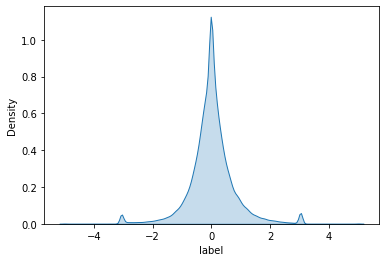

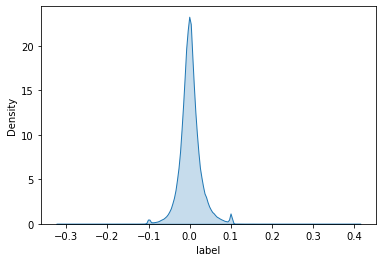

norm data done 

all works done 



In [6]:
# 特征工程、数据清洗，和拆分数据集
x_train, x_test, y_train, y_test, ymean, ystd = scutquant.auto_process(X, 'label', groupby='instrument', select=False)

In [7]:
# 拟合模型并预测
model = scutquant.auto_lrg(x_train, y_train, method='ols')
pred = model.predict(x_test)
pred = pd.DataFrame({'predict': pred}, index=x_test.index)
pred += ymean
pred *= ystd

pred

ols method will be used


predict
datetime   instrument          
2019-12-31 SZ002422   -0.000155
           SZ002456    0.002613
           SZ002460    0.001325
           SZ002466   -0.003542
           SZ002468    0.001350
...                         ...
2021-06-11 SZ300433    0.000702
           SZ300498    0.001948
           SZ300529   -0.002975
           SZ300601   -0.003573
           SZ300628   -0.001789

[101403 rows x 1 columns]

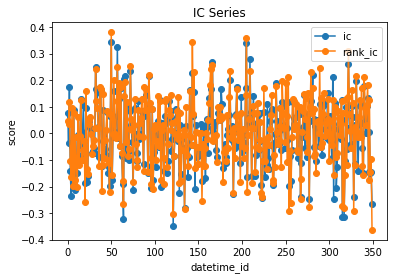

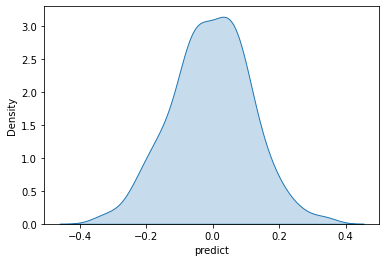

ic= -0.005667740831612271 icir= -0.047236884510529493 rank_ic= 0.002905517027118449 rank_icir= 0.022601293583770554


In [8]:
# 评判拟合优度
ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

In [9]:
# pearson相关系数
r = scutquant.pearson_corr(pred.values, y_test)
r

array([-0.02262009])

In [10]:
# 以下为回测部分，暂时不作要求

df1 = df[df.index.isin(pred.index)]
df1 = df1.reset_index()
df1['t'] = df1['datetime']
df1 = df1.set_index(['datetime', 'instrument']).sort_index()

pred['t'] = df1['t']  
pred['price'] = df1['close']
pred.index.names = ['time', 'code']

acc={
    'cash': 10000000,
    'position': None,
    'available': None,
    'ben_position': None,
}

In [11]:
from scutquant import executor

exe = executor.Executor(generator={'mode': 'generate'}, acc=acc, cost_buy=0.00015, cost_sell=0.00005, min_cost=5, risk_degree=0.95, 
                        auto_offset=True, offset_freq=2)
exe.execute(data=pred)

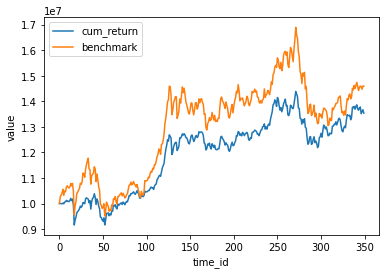

In [12]:
# 当IC为负时，意味着本该买入却给了卖出信号，结果当然是亏损的

import matplotlib.pyplot as plt

user_account, benchmark = exe.user_account.val_hist, exe.benchmark.val_hist
acc_hist, ben_hist = pd.DataFrame({'value': user_account}), pd.DataFrame({'value': benchmark})

plt.plot(acc_hist, label='cum_return')
plt.plot(ben_hist, label='benchmark')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()

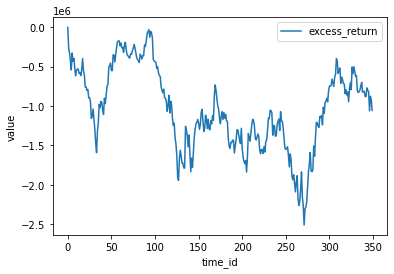

            value
349 -1.055273e+06


In [13]:
excess_return = acc_hist - ben_hist
plt.plot(excess_return, label='excess_return')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()
print(excess_return.iloc[-1:])

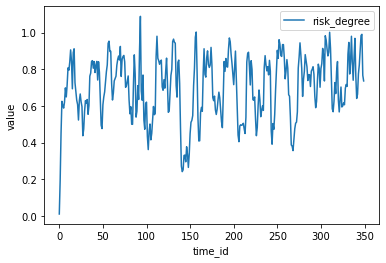

In [14]:
risk = pd.DataFrame({'risk': exe.user_account.risk_curve})

plt.plot(risk, label='risk_degree')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()